# Домашнее задание. Часть 1 (HW)

Задача

1. Сделайте EDA.
   
2. Придумайте эвристику для предсказания целевого класса. На данном этапе нельзя использовать ML, допускаются исключительно наивные методы.
   
3. Реализуйте один из методов векторизации текста и обучите одну из моделей классического ML для данной задачи. Можно использовать любые библиотеки.
   
4. Предложите метрику, разбейте обучающую выборку на обучающую и валидационную. Далее посчитайте её значение для методов, реализованных в пункте 2 и 3.

## EDA

### Подготовка данных

In [1]:
import pandas as pd
import json
import os

# Необходимые переменные для обработки
path_in = r"data\train.csv"
path_out = r"data\content.json"
content = []
text = ''


# Формирование первичного списка сообщений из текстовых данных на основании номеров. 

# Проверка существования предобработанного файла и загрузка его из JSON 
if os.path.isfile(path_out):
    with open(path_out, 'r', encoding='utf-8') as file:
        content= json.load(file)
else: # Формирование преобраюотанного файла
    with open(path_in, "r", encoding='utf-8') as file:
        text = file.read()
    i = 1
    e_pos = 1
    while e_pos > 0:
        s_pos = text.find(f"\n{i},")
        e_pos = text.find(f"\n{i+1},") 
        i+=1
        content.append(text[s_pos + 1:e_pos])
# Запись предобработанного файла
    with open(path_out, "w", encoding='utf-8') as file:
        json.dump(content, file)


In [2]:
# Разделение списка строк на вложенные списки

# Функция разделения строк по индексам
def split_string_by_indices(s, indices):
    
    indices = sorted(indices)
    indices.append(len(s))
    result = []
    
    for i in range(len(indices) - 1):
        start = indices[i]
        end = indices[i + 1]
        result.append(s[start:end])
    return result


# Формирование вложенных списков
data = []
for str in content:
    ft_in = str.find(',')
    sc_in = str.rfind(',')
    indices = [0, ft_in, sc_in]
    sp_str = split_string_by_indices(str, indices)
    data.append(sp_str)


In [3]:
import re
import unicodedata
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Формирование датафрейма
columns = ['id','text','sentiment']
df = pd.DataFrame(data, columns=columns)
df.head()

# Очистка данных от мусора
def remove_tresh(text):
    # Регулярное выражение для поиска адресов электронной почты
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
    # Регулярное выражение для поиска URL
    url_pattern = r'http[s]?://[a-zA-Z0-9./-]+'
    # Регулярное выражение для поиска всех спецсимволов и знаков препинания
    special_char_pattern = r'[^\w\s]'
    # Регулярное выражение для поиска диакретических знаков
    diacretic_char_pattern = r'[\u0300-\u036f]'
    # Удаление email
    text_without_emails = re.sub(email_pattern, '', text)
    # Удаение url
    text_without_urls= re.sub(url_pattern, '', text_without_emails)
    # Удаление spec symbols
    text_without_spec = re.sub(special_char_pattern, '', text_without_urls)
    # Удаление diacretic symbols
    normalized_text = unicodedata.normalize('NFD', text_without_spec)
    cleaned_text = re.sub(diacretic_char_pattern, '', normalized_text)
    cleaned_text = ''.join(char for char in cleaned_text if ord(char) < 128)
    cleaned_text = cleaned_text.lower()
    
    return cleaned_text


def lemmatization(text):
    # Токенизация текста (разделение на слова)
    words = word_tokenize(text)
    # Лемматизация каждого слова
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    # Возвращаем текст обратно в строку
    return ' '.join(lemmas)


# Очистка колонок от мусора
df['text'] = df['text'].apply(remove_tresh)
df['sentiment'] = df['sentiment'].apply(remove_tresh)
df['lemmatization'] = df['text'].apply(lemmatization)



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Santerr80\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Первичный обзор данных

In [4]:
print("Размерность датасета:", df.shape, end="\n\n")

print(df.head(), end="\n\n")

print("Типы данных: ", df.info(), end="\n\n")

print("Поиск пропущенных значений: \n", df.isnull().sum(), end="\n\n")

print("Поиск дубликатов:", df.duplicated().sum())

Размерность датасета: (41156, 4)

  id                                               text           sentiment  \
0  1  advice talk to your neighbours family to excha...            positive   
1  2  coronavirus australia woolworths to give elder...            positive   
2  3  my food stock is not the only one which is emp...            positive   
3  4  me ready to go at supermarket during the covid...  extremely negative   
4  5  as news of the regionas first confirmed covid1...            positive   

                                       lemmatization  
0  advice talk to your neighbour family to exchan...  
1  coronavirus australia woolworth to give elderl...  
2  my food stock is not the only one which is emp...  
3  me ready to go at supermarket during the covid...  
4  a news of the regionas first confirmed covid19...  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41156 entries, 0 to 41155
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ----

### Анализ целевой переменной

sentiment
positive              11422
negative               9917
neutral                7712
extremely positive     6624
extremely negative     5481
Name: count, dtype: int64


<Axes: xlabel='sentiment'>

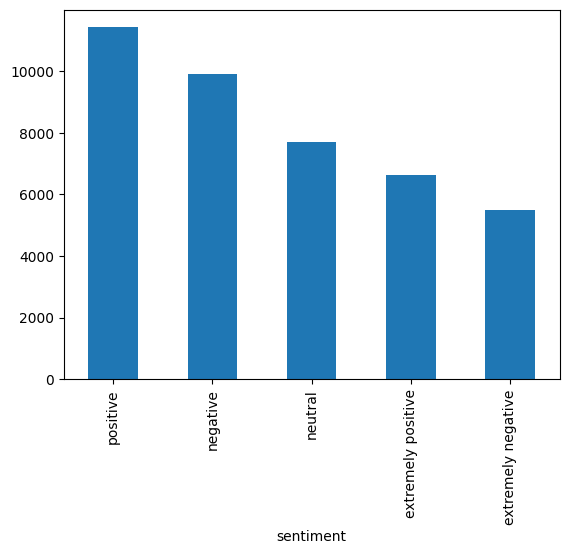

In [5]:
# Частота классов
unique_values_analysis = df['sentiment'].value_counts()

print(unique_values_analysis)

unique_values_analysis.plot(kind='bar')

### Анализ текстовых данных

Общая длина текстов

count    41156.000000
mean       177.527432
std         63.721158
min          0.000000
25%        127.000000
50%        189.000000
75%        234.000000
max        302.000000
Name: text_length, dtype: float64


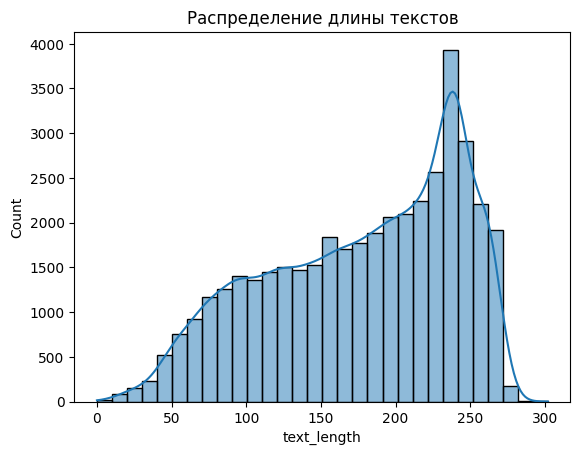

In [6]:
# Общая длина текстов

import matplotlib.pyplot as plt
import seaborn as sns

df['text_length'] = df['lemmatization'].apply(len)

print(df['text_length'].describe())

sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Распределение длины текстов")
plt.show()

Количество слов

count    41156.000000
mean        29.648751
std         11.714116
min          0.000000
25%         20.000000
50%         31.000000
75%         39.000000
max         64.000000
Name: word_count, dtype: float64


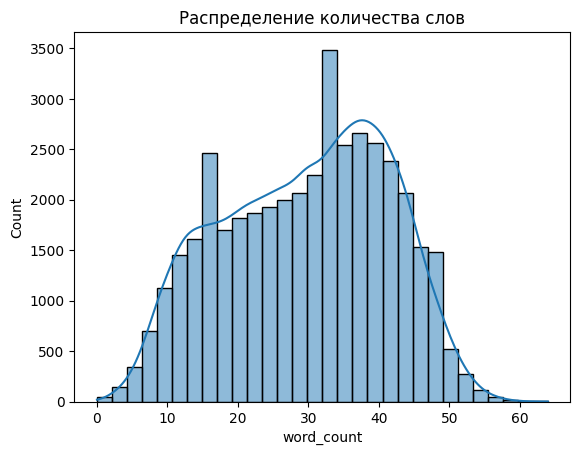

In [7]:
# Частота слов

df['word_count'] = df['lemmatization'].apply(lambda x: len(x.split()))

print(df['word_count'].describe())

sns.histplot(df['word_count'], bins=30, kde=True)
plt.title("Распределение количества слов")
plt.show()


Стоп слова

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Santerr80\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


count    41156.000000
mean        11.004617
std          6.293558
min          0.000000
25%          6.000000
50%         11.000000
75%         15.000000
max         36.000000
Name: stopword_count, dtype: float64


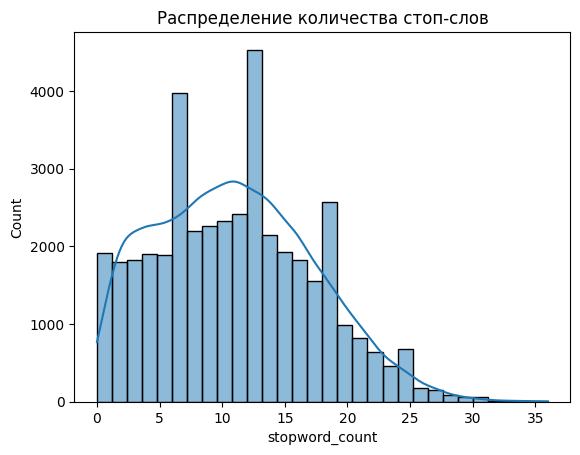

In [8]:
# Стоп слова

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Подсчет количества стоп-слов
df['stopword_count'] = df['lemmatization'].apply(lambda x: sum(1 for word in x.split() if word.lower() in stop_words))

print(df['stopword_count'].describe())

# Распределение стоп-слов
sns.histplot(df['stopword_count'], bins=30, kde=True)
plt.title("Распределение количества стоп-слов")
plt.show()

Частотный анализ слов

[('the', 44698), ('to', 38326), ('a', 26280), ('and', 23964), ('of', 21506), ('in', 19113), ('coronavirus', 17953), ('for', 14029), ('covid19', 13584), ('is', 12239), ('are', 11333), ('on', 9388), ('you', 9240), ('price', 8912), ('i', 8829), ('store', 8133), ('this', 7926), ('at', 7771), ('supermarket', 7706), ('it', 7679), ('food', 7197), ('grocery', 6728), ('with', 6620), ('that', 6270), ('we', 6145), ('have', 6145), ('be', 5741), ('people', 5539), ('from', 5283), ('consumer', 5126), ('amp', 4954), ('all', 4781), ('not', 4748), ('your', 4592), ('will', 4496), ('my', 4179), ('our', 4034), ('can', 3981), ('ha', 3809), ('they', 3778), ('out', 3776), ('up', 3766), ('by', 3715), ('more', 3699), ('19', 3697), ('or', 3686), ('shopping', 3589), ('but', 3518), ('if', 3513), ('online', 3413)]


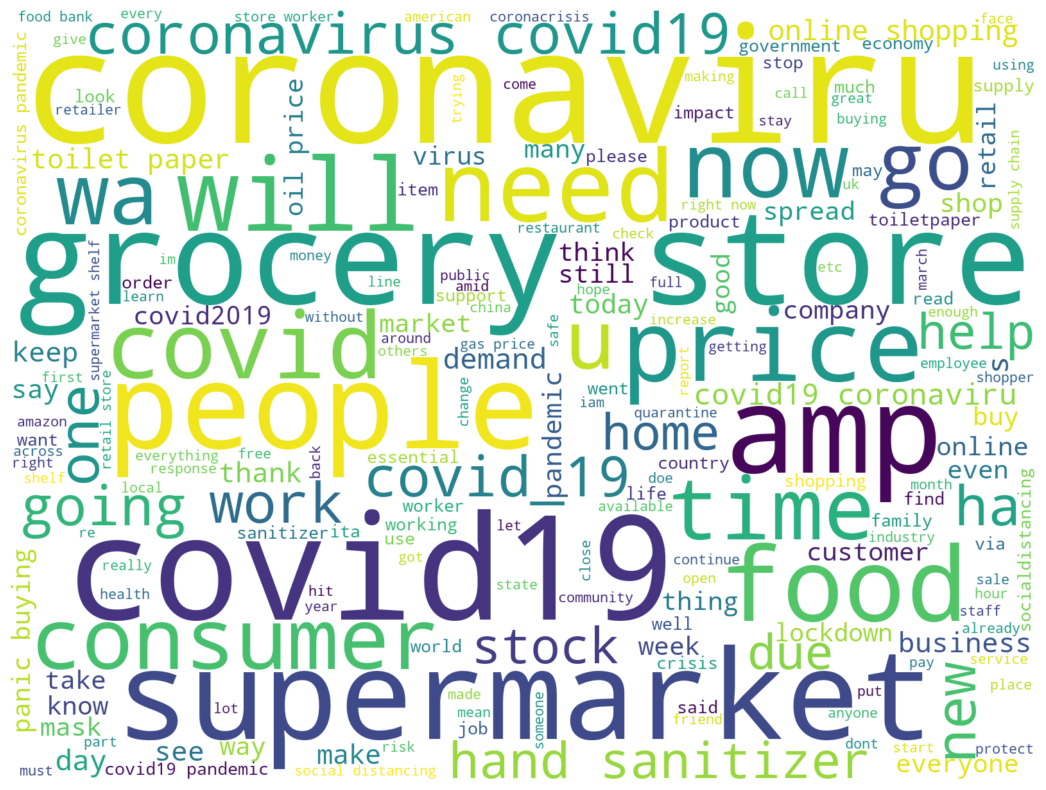

In [9]:
from collections import Counter
from wordcloud import WordCloud

# Подсчет частотности слов
all_words = ' '.join(df['lemmatization']).split()
word_freq = Counter(all_words)

# Топ-10 самых частотных слов
print(word_freq.most_common(50))

# Облако слов
wordcloud = WordCloud(width=1600, height=1200, background_color='white').generate(' '.join(all_words))

plt.figure(figsize=(30, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Анализ уникальных слов

In [10]:
# Подсчет уникальных слов
df['unique_word_count'] = df['lemmatization'].apply(lambda x: len(set(x.split())))

# Соотношение уникальных слов к общему количеству слов
df['unique_to_total_ratio'] = df['unique_word_count'] / df['word_count']

# Статистика
print(df['unique_to_total_ratio'].describe())

count    41149.000000
mean         0.912373
std          0.069619
min          0.222222
25%          0.866667
50%          0.916667
75%          0.966667
max          1.000000
Name: unique_to_total_ratio, dtype: float64


Обнаружение выбросов

In [11]:
# Тексты с минимальной длиной
print(df[df['text_length'] == df['text_length'].min()])

# Тексты с максимальной длиной
print(df[df['text_length'] == df['text_length'].max()])

          id                                               text sentiment  \
5213    5214                                      \n\n\n\n        neutral   
13842  13843         \n\n\n\n                               ...   neutral   
16919  16920                                                      neutral   
18436  18437                                \n\n            ...   neutral   
29887  29888                                 \n\n     \n\n\n\n    neutral   
32454  32455                                                      neutral   
36780  36781                           \n\n\n\n             ...   neutral   

      lemmatization  text_length  word_count  stopword_count  \
5213                           0           0               0   
13842                          0           0               0   
16919                          0           0               0   
18436                          0           0               0   
29887                          0           0               0   

Анализ тональности

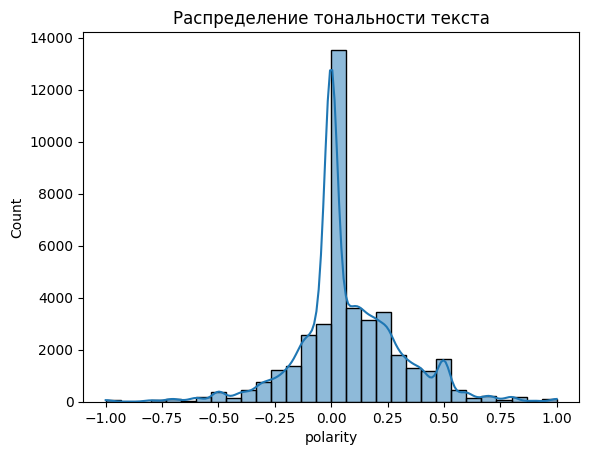

In [12]:
from textblob import TextBlob

# Вычисление полярности
df['polarity'] = df['lemmatization'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Распределение тональности
sns.histplot(df['polarity'], bins=30, kde=True)
plt.title("Распределение тональности текста")
plt.show()

Анализ триграмм

In [13]:
# Функция для извлечения триграмм
import nltk

nltk.download('punkt_tab')


def extract_trigrams(text):
    blob = TextBlob(text)
    return list(blob.ngrams(n=3))


df['trigrams'] = df['lemmatization'].apply(extract_trigrams)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Santerr80\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [14]:
from collections import Counter

# Объединяем все триграммы в один список
all_trigrams = [tuple(trigram) for sublist in df['trigrams'] for trigram in sublist]

# Подсчитываем частотность каждой триграммы
trigram_counts = Counter(all_trigrams)

# Преобразуем результат в DataFrame
trigram_df = pd.DataFrame(trigram_counts.items(), columns=['Trigram', 'Count'])

print(trigram_df['Count'].describe())

count    824441.000000
mean          1.380181
std           4.204581
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        2055.000000
Name: Count, dtype: float64


Корреляции

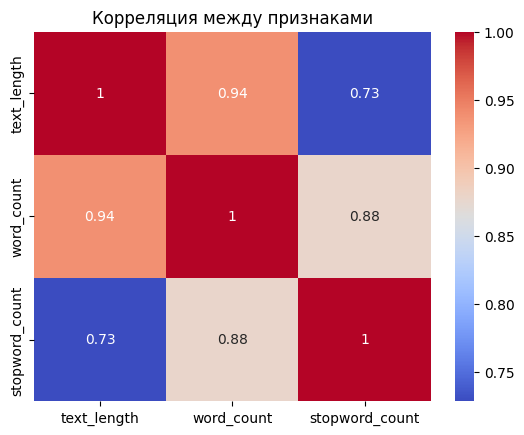

In [15]:
# Корреляционная матрица
correlation_matrix = df[['text_length', 'word_count', 'stopword_count']].corr()

# Тепловая карта
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Корреляция между признаками")
plt.show()

### Выводы по результатам EDA

1. Наиболее часто встречающиеся слова - "сoronavirus", "covid19"
2. Наибольшее распространение количества стоп-слов в предложениях 5, 10, 15
3. Среднее количество слов предложениях - 29
4. Анализ тональности текстов показал нормальное распределение с выбросом значений в районе 0.25, что говорит о нейтральности контекста информации.
5. Cреднее количество стоп-слов в предложениях - 11
6. Перед обучением требуется проведение чистки  текста от адресов электронной почты, адресов URL, знаков препинания и спецсимволов.
7. Выделенные числовые признаки хорошо коррелируют между собой.

## Эвристика для предсказания целевого класса. 

<Axes: xlabel='weight'>

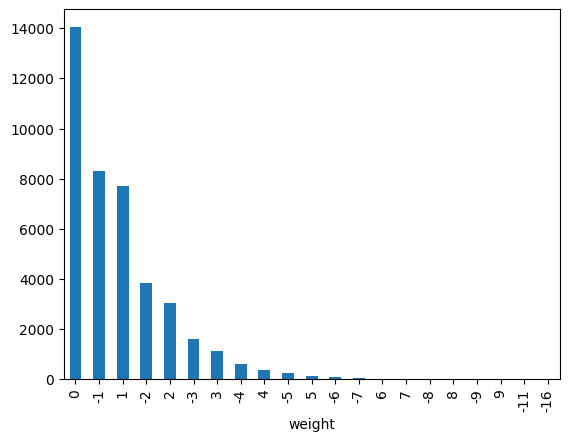

In [16]:
# Классы 
classes = df['sentiment'].unique()

# Списки слов негативного и позитивного контекста
positive_list = []
negative_list = []

# Заполнение списков
with open(r"data\negative-words.txt", "r") as f:
    for line in f:
        negative_list.append(line.strip())

with open(r"data\positive-words.txt", "r") as f:
    for line in f:
        positive_list.append(line.strip())

# Функция подсчета количества слов контекста
def count_words(text, word_list):
    words_in_text = text.split()
    return sum(words_in_text.count(word) for word in word_list)

df['positive'] = df["lemmatization"].apply(lambda x: count_words(x, positive_list))

df['negative']= df["lemmatization"].apply(lambda x: count_words(x, negative_list))

# Расчет коэффициента позитивности текста 
df['weight'] = df['positive'] - df['negative']

values_analysis = df['weight'].value_counts()
values_analysis.plot(kind="bar")



## Обучение модели

Определение классов на основе количества положительных и отрецательных слов 

In [23]:
import numpy as np
conditions = [
    df['weight'] == 0,           
    (df['weight'] > 0) & (df['weight'] <= 2),  
    (df['weight'] > 2),       
    (df['weight'] < 0) & (df['weight'] >= -2), 
    (df['weight'] < -2)         
]

values = [3, 4, 5, 2, 1]  # Значения для classes

df['classes'] = np.select(conditions, values)

df.to_json(r'data\')



Разделение на тестовую и тренировочную выборки.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['lemmatization'],\
    df['classes'], test_size=0.2, random_state=42)

Векторизация текста с использованием TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

Обучение модели

In [26]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

d:\URFU\III MOMO\HW1\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

## Метрика и оценка модели.

In [27]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.62

Classification Report:
              precision    recall  f1-score   support

           1       0.58      0.09      0.16       528
           2       0.62      0.69      0.65      2416
           3       0.60      0.69      0.64      2798
           4       0.66      0.69      0.67      2146
           5       0.55      0.05      0.10       344

    accuracy                           0.62      8232
   macro avg       0.60      0.44      0.44      8232
weighted avg       0.62      0.62      0.60      8232

